In [2]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 2,
    "lines.markersize": 3,
})


# print(os.getcwd())
# Load the file
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")
# Check the first few rows
print(df.dtypes)
df.head()

datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
0,2022-01-01 00:00:00,BZN|ES,Solar,75.0
1,2022-01-01 01:00:00,BZN|ES,Solar,75.0
2,2022-01-01 02:00:00,BZN|ES,Solar,75.0
3,2022-01-01 03:00:00,BZN|ES,Solar,75.0
4,2022-01-01 04:00:00,BZN|ES,Solar,75.0


In [3]:
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")

# Convert datetime column to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Rename the generation column
df['generation'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['datetime', 'generation']].sort_values('datetime')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Total records: {len(df)}")

# FILTER FOR JUNE TO AUGUST ONLY (months 6-8)
df['month'] = df['datetime'].dt.month
df_filtered = df[df['month'].isin([6, 7, 8])].copy()
df_filtered = df_filtered.drop('month', axis=1)

print(f"\n" + "="*60)
print("FILTERED DATA: JUNE TO AUGUST ONLY")
print("="*60)
print(f"Filtered data range: {df_filtered['datetime'].min()} to {df_filtered['datetime'].max()}")
print(f"Total records after filtering: {len(df_filtered)}")
print(f"Records removed: {len(df) - len(df_filtered)}")

datetime      datetime64[ns]
generation           float64
dtype: object
             datetime  generation
0 2022-01-01 00:00:00        75.0
1 2022-01-01 01:00:00        75.0
2 2022-01-01 02:00:00        75.0
3 2022-01-01 03:00:00        75.0
4 2022-01-01 04:00:00        75.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301

FILTERED DATA: JUNE TO AUGUST ONLY
Filtered data range: 2022-06-01 00:00:00 to 2024-08-31 23:00:00
Total records after filtering: 6624
Records removed: 19677


In [4]:
# Data quality check and outlier detection
print("Data Quality Analysis (June-August data):")
print("=" * 60)

# Check for missing values
missing_count = df_filtered['generation'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df_filtered['generation'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df_filtered['generation'].quantile(0.25)
Q3 = df_filtered['generation'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df_filtered['generation'] < lower_bound) | (df_filtered['generation'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df_filtered['generation'].min():.2f} MWh")
print(f"  Max: {df_filtered['generation'].max():.2f} MWh")
print(f"  Mean: {df_filtered['generation'].mean():.2f} MWh")
print(f"  Median: {df_filtered['generation'].median():.2f} MWh")
print(f"  Std: {df_filtered['generation'].std():.2f} MWh")
print(f"  95th percentile: {df_filtered['generation'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df_filtered['generation'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df_filtered.copy()
max_reasonable = df_filtered['generation'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['generation'] > max_reasonable, 'generation'] = max_reasonable
df_cleaned.loc[df_cleaned['generation'] < 0, 'generation'] = 0  # Remove any negative values

capped_count = (df_filtered['generation'] != df_cleaned['generation']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis (June-August data):
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 0.00 MWh
  Max: 21280.00 MWh
  Mean: 6573.79 MWh
  Median: 3692.00 MWh
  Std: 6585.92 MWh
  95th percentile: 18320.40 MWh
  99th percentile: 20417.16 MWh

Capped 0 extreme values to max: 22458.88 MWh
Data is ready for modeling


**Features created. Overall are 35 features**

In [5]:
# Create time-based features for XGBoost - MINIMAL LAG DEPENDENCY
def create_features(df):
    """
    Create features focusing on time and solar patterns, NOT historical values
    This ensures forecasting works properly for future dates
    """
    df = df.copy()
    
    # Basic time features
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['weekofyear'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    
    # Cyclical encoding (CRITICAL for time patterns)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Solar elevation (MOST IMPORTANT for PV forecasting)
    hour_angle = (df['hour'] - 12) * 15  # degrees from solar noon
    declination = 23.45 * np.sin(2 * np.pi * (df['dayofyear'] - 81) / 365)
    latitude = 45  # Europe
    
    solar_elevation_rad = np.arcsin(
        np.sin(np.radians(latitude)) * np.sin(np.radians(declination)) +
        np.cos(np.radians(latitude)) * np.cos(np.radians(declination)) * 
        np.cos(np.radians(hour_angle))
    )
    df['solar_elevation'] = np.degrees(solar_elevation_rad).clip(lower=0)
    
    # Clear sky irradiance proxy (based on solar elevation)
    df['clearsky_ghi'] = np.where(
        df['solar_elevation'] > 0,
        1000 * (np.sin(np.radians(df['solar_elevation'])) ** 1.2),
        0
    )
    
    # Solar azimuth approximation (sun direction)
    df['solar_azimuth'] = np.where(
        df['hour'] < 12,
        -1 * (12 - df['hour']) / 12,  # Morning: -1 to 0
        (df['hour'] - 12) / 12  # Afternoon: 0 to 1
    )
    
    # Day length (hours of daylight)
    df['day_length'] = 12 + 3.8 * np.sin(2 * np.pi * (df['dayofyear'] - 81) / 365)
    
    # Time of day indicators
    df['is_daylight'] = (df['solar_elevation'] > 0).astype(int)
    df['is_peak_hours'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
    df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
    df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] <= 18)).astype(int)
    
    # Season indicators
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
    df['is_fall'] = df['month'].isin([9, 10, 11]).astype(int)
    
    # Weekend/weekday
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Interaction features (hour × solar features)
    df['hour_x_elevation'] = df['hour'] * df['solar_elevation']
    df['hour_x_clearsky'] = df['hour'] * df['clearsky_ghi']
    df['month_x_hour'] = df['month'] * df['hour']
    df['dayofyear_x_hour'] = df['dayofyear'] * df['hour']
    
    # Higher order solar features
    df['solar_elevation_sq'] = df['solar_elevation'] ** 2
    df['clearsky_ghi_sq'] = df['clearsky_ghi'] ** 2
    
    return df

# Create features (NO lag features that depend on generation values)
print("Creating features without lag dependency...")
df = create_features(df)

# No need to drop rows since we have no lag features
df_clean = df.copy()

print(f"Total data points: {len(df_clean)}")
print(f"Features created: {len([col for col in df_clean.columns if col not in ['datetime', 'generation']])}")
print(f"\nFeature list:")
print([col for col in df_clean.columns if col not in ['datetime', 'generation']])

# Split data into train (70%), validation (20%), and test (10%)
total_rows = len(df_clean)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df_clean.iloc[:train_size].copy()
val_df = df_clean.iloc[train_size:train_size + val_size].copy()
test_df = df_clean.iloc[train_size + val_size:].copy()

print(f"\nTraining set: {len(train_df)} records")
print(f"  Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"\nValidation set: {len(val_df)} records")
print(f"  Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"\nTest set: {len(test_df)} records")
print(f"  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

Creating features without lag dependency...
Total data points: 6624
Features created: 35

Feature list:
['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos', 'solar_elevation', 'clearsky_ghi', 'solar_azimuth', 'day_length', 'is_daylight', 'is_peak_hours', 'is_morning', 'is_afternoon', 'is_summer', 'is_winter', 'is_spring', 'is_fall', 'is_weekend', 'hour_x_elevation', 'hour_x_clearsky', 'month_x_hour', 'dayofyear_x_hour', 'solar_elevation_sq', 'clearsky_ghi_sq']

Training set: 4636 records
  Period: 2022-06-01 00:00:00 to 2024-06-10 03:00:00

Validation set: 1324 records
  Period: 2024-06-10 04:00:00 to 2024-08-04 07:00:00

Test set: 664 records
  Period: 2024-08-04 08:00:00 to 2024-08-31 23:00:00


**Prepare features and target for XGboost**

* x_train is the column of "feature_cols" extracted from train_df.
* y_train is the predicted value of power generation.

In [6]:
# Prepare features and target for XGBoost
feature_cols = [col for col in train_df.columns if col not in ['datetime', 'generation']]

X_train = train_df[feature_cols]
y_train = train_df['generation']

X_val = val_df[feature_cols]
y_val = val_df['generation']

X_test = test_df[feature_cols]
y_test = test_df['generation']

print(f"Features used: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:15]}")

# Create XGBoost model optimized for solar forecasting
model = xgb.XGBRegressor(
    n_estimators=3000,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    min_child_weight=1,
    gamma=0,
    reg_alpha=0,
    reg_lambda=0.5,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    early_stopping_rounds=150,
    eval_metric='rmse',
    max_bin=512
)

print("\nTraining XGBoost model on June-August data...")
print("=" * 60)
print("Model Configuration:")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - subsample: {model.subsample}")
print(f"  - colsample_bytree: {model.colsample_bytree}")
print("=" * 60)

# Train the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print("\nTraining complete!")
print(f"Best iteration: {model.best_iteration}")
print(f"Best validation RMSE: {model.best_score:.4f}")

Features used: 35
Sample features: ['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin']

Training XGBoost model on June-August data...
Model Configuration:
  - n_estimators: 3000
  - max_depth: 12
  - learning_rate: 0.05
  - subsample: 0.9
  - colsample_bytree: 0.9
[0]	validation_0-rmse:5562.47310	validation_1-rmse:7712.09835
[100]	validation_0-rmse:94.72944	validation_1-rmse:2426.28640
[200]	validation_0-rmse:25.23158	validation_1-rmse:2396.33715
[300]	validation_0-rmse:11.93002	validation_1-rmse:2397.29855
[362]	validation_0-rmse:7.95676	validation_1-rmse:2397.46898

Training complete!
Best iteration: 213
Best validation RMSE: 2396.2508


Top 20 Most Important Features:
               feature  importance
23        is_afternoon    0.289020
29    hour_x_elevation    0.286671
21       is_peak_hours    0.239804
30     hour_x_clearsky    0.094073
8             hour_sin    0.054005
3                 year    0.008921
0                 hour    0.007129
20         is_daylight    0.002906
12       dayofyear_sin    0.002573
18       solar_azimuth    0.002207
6           weekofyear    0.001841
5            dayofyear    0.001622
9             hour_cos    0.001431
33  solar_elevation_sq    0.001218
16     solar_elevation    0.000864
17        clearsky_ghi    0.000732
19          day_length    0.000704
1                  day    0.000702
14       dayofweek_sin    0.000593
13       dayofyear_cos    0.000533


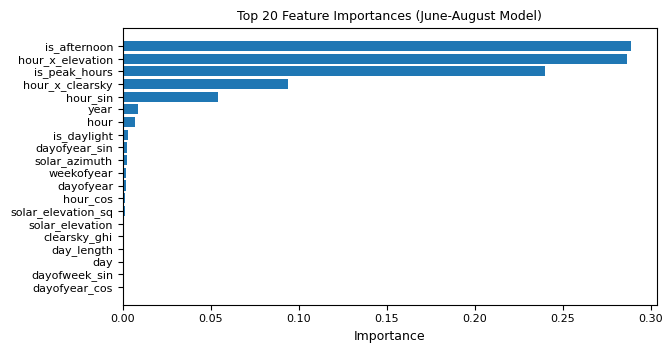

In [7]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 50)
print(feature_importance.head(20).to_string())

# Plot feature importance
plt.figure(figsize=(6.8, 3.6))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (June-August Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Validate model on validation set
val_pred = model.predict(X_val)
val_pred = np.clip(val_pred, 0, None)

val_mae = mean_absolute_error(y_val, val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

threshold = 10
significant_mask = y_val >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((y_val[significant_mask] - val_pred[significant_mask]) / y_val[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")

Validation Set Performance:
MAE:  1610.59 MWh
RMSE: 2396.25 MWh
MAPE (generation >= 10 MWh): 33.47%


In [9]:
# Test model on test set
test_pred = model.predict(X_test)
test_pred = np.clip(test_pred, 0, None)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

threshold = 10
significant_mask = y_test >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((y_test[significant_mask] - test_pred[significant_mask]) / y_test[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")

Test Set Performance:
MAE:  1405.24 MWh
RMSE: 2159.10 MWh
MAPE (generation >= 10 MWh): 35.40%


In [10]:
# Create forecast for June to August 2025
print("Forecasting for June to August 2025...")
print("=" * 60)

# Create future dates for June-August 2025
future_dates = pd.date_range(start='2025-06-01 00:00:00', end='2025-08-31 23:00:00', freq='1H')
future_df = pd.DataFrame({'datetime': future_dates})

print(f"Forecast period: {future_df['datetime'].min()} to {future_df['datetime'].max()}")
print(f"Total hours to forecast: {len(future_df)}")

# Create features for 2025
future_features = create_features(future_df)

feature_cols_check = [col for col in feature_cols if col in future_features.columns]
print(f"\nFeatures available: {len(feature_cols_check)}/{len(feature_cols)}")

X_future = future_features[feature_cols].copy()

# Check for any NaN values
nan_count = X_future.isna().sum().sum()
if nan_count > 0:
    print(f"WARNING: {nan_count} NaN values found")
    print("Filling NaN with 0...")
    X_future = X_future.fillna(0)
else:
    print("No NaN values - ready for prediction!")

# Make predictions
print("\nGenerating June-August 2025 forecasts...")
forecast_values = model.predict(X_future)
forecast_values = np.clip(forecast_values, 0, None)

# Create forecast dataframe
forecast_2025 = pd.DataFrame({
    'datetime': future_dates,
    'yhat': forecast_values
})

forecast_2025['hour'] = forecast_2025['datetime'].dt.hour
forecast_2025['month'] = forecast_2025['datetime'].dt.month

print("\n" + "="*60)
print("FORECAST COMPLETE")
print("="*60)
print(f"Total predictions: {len(forecast_2025)}")
print(f"\nForecast statistics:")
print(f"  Min:  {forecast_2025['yhat'].min():.2f} MWh")
print(f"  Max:  {forecast_2025['yhat'].max():.2f} MWh")
print(f"  Mean: {forecast_2025['yhat'].mean():.2f} MWh")

# Check monthly pattern
print(f"\nAverage forecast by month:")
monthly_avg = forecast_2025.groupby('month')['yhat'].mean()
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug'}
for month in range(6, 9):
    print(f"  {month_names[month]}: {monthly_avg[month]:>8.2f} MWh")

Forecasting for June to August 2025...
Forecast period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
Total hours to forecast: 2208

Features available: 35/35
No NaN values - ready for prediction!

Generating June-August 2025 forecasts...

FORECAST COMPLETE
Total predictions: 2208

Forecast statistics:
  Min:  65.25 MWh
  Max:  19952.98 MWh
  Mean: 6903.12 MWh

Average forecast by month:
  Jun:  6725.33 MWh
  Jul:  7137.45 MWh
  Aug:  6840.86 MWh


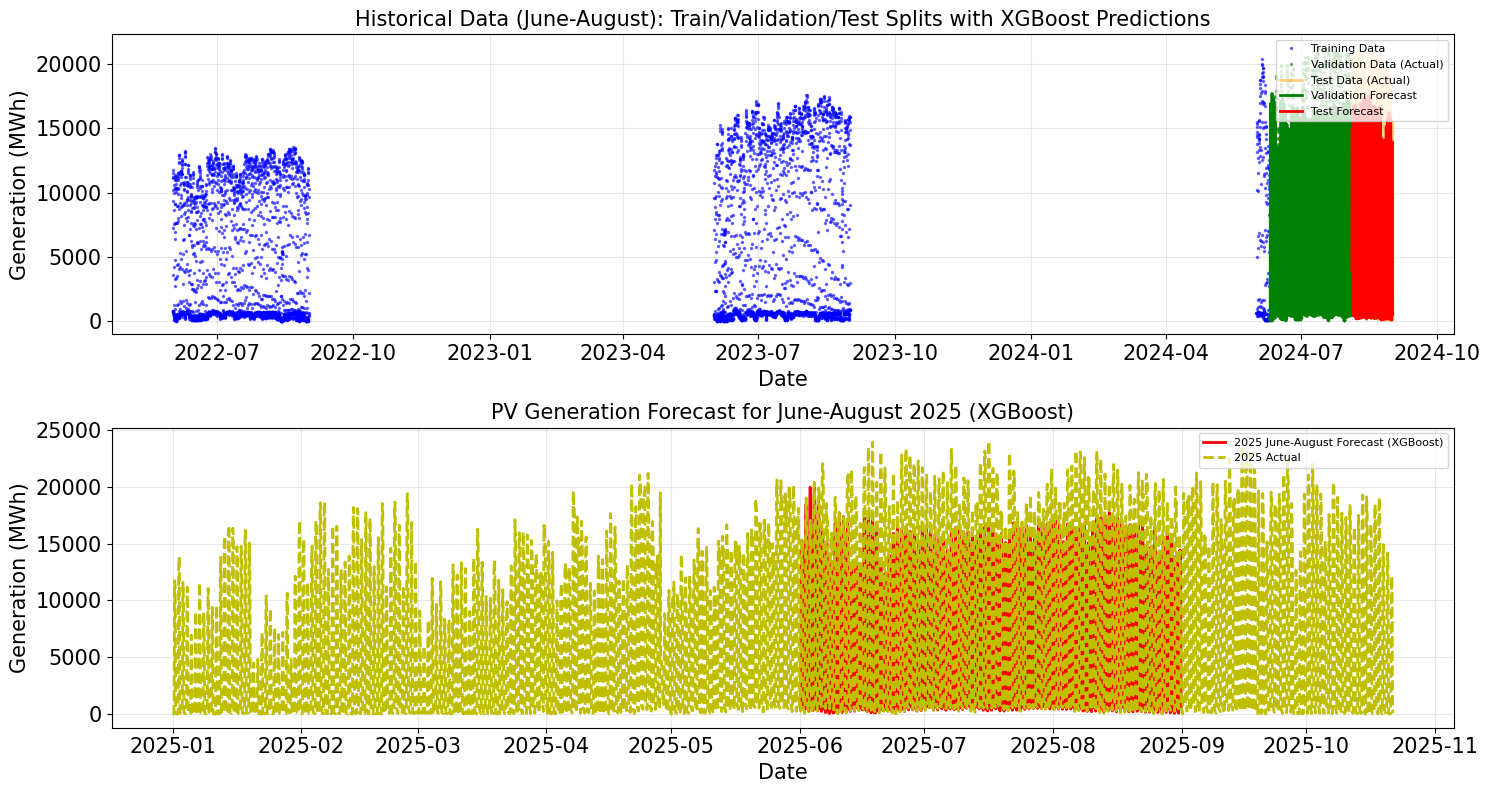

In [11]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Historical data with splits
ax1 = axes[0]
ax1.plot(train_df['datetime'], train_df['generation'], 'b.', label='Training Data', alpha=0.5)#, markersize=2)
ax1.plot(val_df['datetime'], val_df['generation'], 'g.', label='Validation Data (Actual)', alpha=0.5)#, markersize=2)
ax1.plot(test_df['datetime'], test_df['generation'], 'orange', label='Test Data (Actual)', alpha=0.5)#, markersize=2)
ax1.plot(val_df['datetime'].values, val_pred, 'g-', label='Validation Forecast')#, linewidth=1, alpha=0.7)
ax1.plot(test_df['datetime'].values, test_pred, 'r-', label='Test Forecast')#, linewidth=1, alpha=0.7)

ax1.set_title('Historical Data (June-August): Train/Validation/Test Splits with XGBoost Predictions', fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Generation (MWh)', fontsize=15)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast
ax2 = axes[1]
ax2.plot(forecast_2025['datetime'], forecast_2025['yhat'], 'r-', label='2025 June-August Forecast (XGBoost)')#, linewidth=1)
df_2025_actual = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025_actual['datetime'] = pd.to_datetime(df_2025_actual['datetime'])
df_2025_actual['generation'] = df_2025_actual['Generation (MWh)']
ax2.plot(df_2025_actual['datetime'], df_2025_actual['generation'], 'y--', label='2025 Actual')#, linewidth=1)

ax2.set_title('PV Generation Forecast for June-August 2025 (XGBoost)', fontsize=15)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_xlabel('Date', fontsize=15)
ax2.set_ylabel('Generation (MWh)', fontsize=15)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

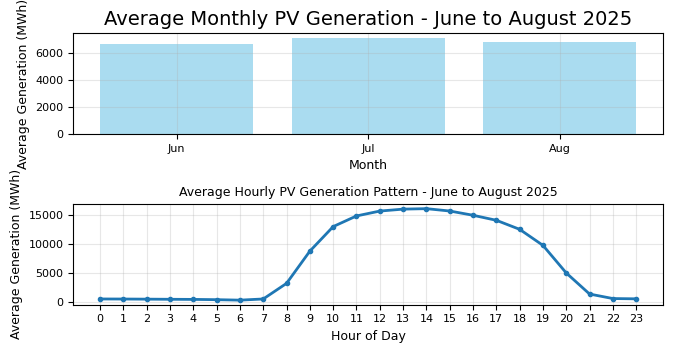

In [12]:
# Analyze seasonal patterns in the forecast
monthly_avg = forecast_2025.groupby('month')['yhat'].mean()
hourly_avg = forecast_2025.groupby('hour')['yhat'].mean()

fig, axes = plt.subplots(2, 1, figsize=(6.8, 3.6))

# Plot monthly pattern
ax1 = axes[0]
ax1.bar(monthly_avg.index, monthly_avg.values, alpha=0.7, color='skyblue')
ax1.set_title('Average Monthly PV Generation - June to August 2025', fontsize=14)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Generation (MWh)')
ax1.set_xticks(range(6, 9))
ax1.set_xticklabels(['Jun', 'Jul', 'Aug'])
ax1.grid(True, alpha=0.3)

# Plot hourly pattern
ax2 = axes[1]
ax2.plot(hourly_avg.index, hourly_avg.values, marker='o')#, markersize=2)#, linewidth=2)
ax2.set_title('Average Hourly PV Generation Pattern - June to August 2025')#, fontsize=14)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Generation (MWh)')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Export 2025 forecast to CSV
forecast_export = forecast_2025[['datetime', 'yhat']].copy()
forecast_export['timestamp'] = forecast_export['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh'
})

output_file = 'pv_forecast_2025_june_august_xgboost.csv'
#forecast_export.to_csv(output_file, index=False)
print(f"June-August 2025 forecast exported to: {output_file}")
print(f"\nSummary statistics:")
print(forecast_export.describe())

June-August 2025 forecast exported to: pv_forecast_2025_june_august_xgboost.csv

Summary statistics:
       Forecast_Generation_MWh
count              2208.000000
mean               6903.124023
std                6664.381348
min                  65.248619
25%                 543.121796
50%                3648.875000
75%               14039.235107
max               19952.978516


In [14]:
# Load actual 2025 data for comparison
df_2025_actual = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025_actual['datetime'] = pd.to_datetime(df_2025_actual['datetime'])
df_2025_actual['generation'] = df_2025_actual['Generation (MWh)']
df_2025_actual = df_2025_actual[['datetime', 'generation']].sort_values('datetime')

# Filter for June-August 2025
df_2025_actual['month'] = df_2025_actual['datetime'].dt.month
df_2025_actual_filtered = df_2025_actual[df_2025_actual['month'].isin([6, 7, 8])].copy()

print(f"2025 actual data (June-August) loaded:")
print(f"  Period: {df_2025_actual_filtered['datetime'].min()} to {df_2025_actual_filtered['datetime'].max()}")
print(f"  Total records: {len(df_2025_actual_filtered)}")

print(f"{df_2025_actual_filtered.describe()}")

# Merge forecast with actual 2025 data
comparison = pd.merge(
    forecast_2025[['datetime', 'yhat']], 
    df_2025_actual_filtered[['datetime', 'generation']], 
    on='datetime', 
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
mae = mean_absolute_error(comparison['generation'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['generation'], comparison['yhat']))
r2 = r2_score(comparison['generation'], comparison['yhat'])

threshold = 10
significant_mask = comparison['generation'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['generation'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['generation'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 June-August Forecast Performance Metrics:")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
print(f"R²:   {r2:.4f}")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

2025 actual data (June-August) loaded:
  Period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
  Total records: 2208
                  datetime    generation        month
count                 2208   2208.000000  2208.000000
mean   2025-07-16 23:30:00   8784.291063     7.010870
min    2025-06-01 00:00:00      7.000000     6.000000
25%    2025-06-23 23:45:00    611.750000     6.000000
50%    2025-07-16 23:30:00   5777.000000     7.000000
75%    2025-08-08 23:15:00  17613.250000     8.000000
max    2025-08-31 23:00:00  23999.000000     8.000000
std                    NaN   8509.100564     0.814387

Matched records: 2208

2025 June-August Forecast Performance Metrics:
MAE:  2035.54 MWh
RMSE: 3144.05 MWh
R²:   0.8634
MAPE (generation >= 10 MWh): 36.04%


Installed Capacity (95th percentile): 21443.00 MWh



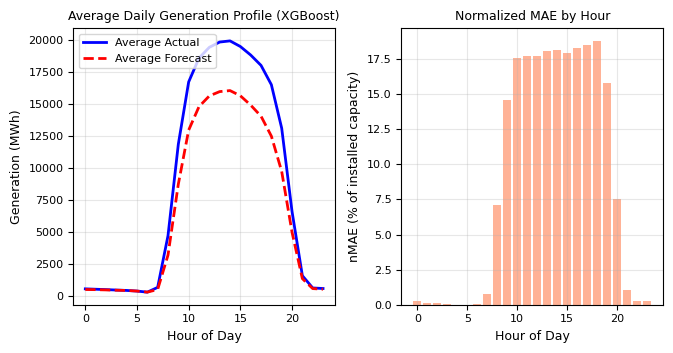

In [15]:
# Calculate installed capacity (95th percentile of all actual data as proxy)
installed_capacity = comparison['generation'].quantile(0.95)
print(f"Installed Capacity (95th percentile): {installed_capacity:.2f} MWh\n")

# Create hourly averages for error analysis
comparison['hour'] = comparison['datetime'].dt.hour

hourly_metrics = comparison.groupby('hour').agg({
    'generation': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['generation'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(6.8, 3.6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['generation'], 'b-', label='Average Actual')#, linewidth=2)
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast')#, linewidth=2)
plt.title('Average Daily Generation Profile (XGBoost)')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MWh)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6, color='coral')
plt.title('Normalized MAE by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

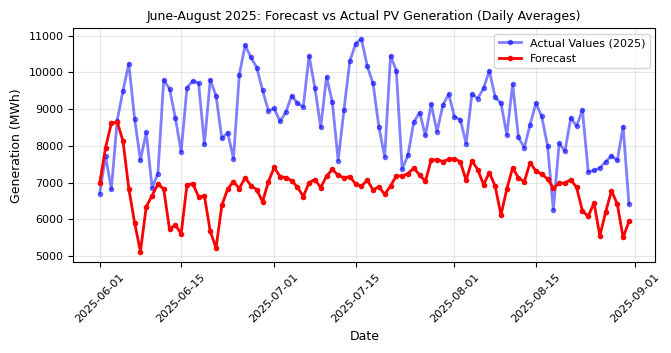

In [16]:
# Plot comparison between forecast and actual values
plt.figure(figsize=(6.8, 3.6))

# Create daily averages for better visualization
daily_comparison = comparison.set_index('datetime').resample('D').mean().reset_index()

plt.plot(daily_comparison['datetime'], daily_comparison['generation'], 'b-', marker='o', label='Actual Values (2025)', alpha=0.5)#, markersize=4)
plt.plot(daily_comparison['datetime'], daily_comparison['yhat'], 'r-', marker='o', label='Forecast')#, linewidth=2)

plt.title("June-August 2025: Forecast vs Actual PV Generation (Daily Averages)")
plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
daily_comparison.head()

,datetime,yhat,generation,hour
0,2025-06-01,6993.729980,6706.583333,11.5
1,2025-06-02,7947.238770,7721.458333,11.5
2,2025-06-03,8622.053711,6816.041667,11.5
3,2025-06-04,8652.249023,8691.416667,11.5
4,2025-06-05,8133.592285,9506.333333,11.5


In [18]:
# Monthly performance metrics
print("\nMonthly Performance Metrics:")
print("===========================")


comparison['year_month'] = comparison['datetime'].dt.to_period('M')
unique_months = sorted(comparison['year_month'].unique())

monthly_metrics_data = []

for month_period in unique_months:
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    if len(month_data) < 2:
        continue
    
    actual = month_data['generation'].values
    predicted = month_data['yhat'].values
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    # Calculate nRMSE (normalized RMSE as percentage of installed capacity)
    nrmse = (rmse / installed_capacity) * 100

    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    monthly_metrics_data.append({
        'Month': month_period.strftime('%b'),
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'nRMSE': nrmse
    })
    
    print(f"{month_period.strftime('%B %Y')}:")
    print(f"  MAE: {mae:.2f} MWh")
    print(f"  RMSE: {rmse:.2f} MWh")
    if not np.isnan(mape):
        print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}")
    
    print(f"  nRMSE: {nrmse:.2f}%")
    print("---------------------------")

metrics_df = pd.DataFrame(monthly_metrics_data)
print("\nMonthly metrics saved to DataFrame")


Monthly Performance Metrics:
June 2025:
  MAE: 2354.15 MWh
  RMSE: 3595.99 MWh
  MAPE: 52.45%
  R²: 0.8196
  nRMSE: 16.77%
---------------------------
July 2025:
  MAE: 2087.91 MWh
  RMSE: 3149.52 MWh
  MAPE: 23.90%
  R²: 0.8638
  nRMSE: 14.69%
---------------------------
August 2025:
  MAE: 1674.84 MWh
  RMSE: 2627.29 MWh
  MAPE: 35.45%
  R²: 0.9045
  nRMSE: 12.25%
---------------------------

Monthly metrics saved to DataFrame


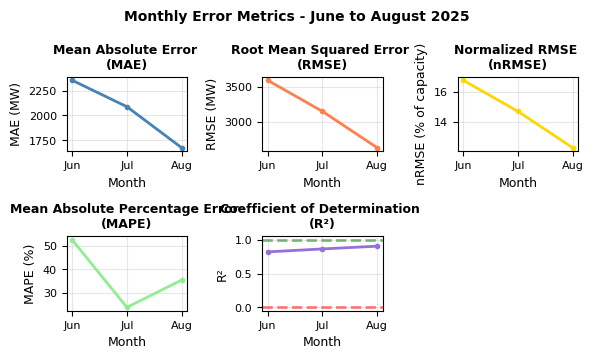


Overall Statistics:
  Best R² Month: Aug (0.9045)
  Worst R² Month: Jun (0.8196)
  Lowest MAE Month: Aug (1674.84 MW)
  Highest MAE Month: Jun (2354.15 MW)
  Lowest nRMSE Month: Aug (12.25%)
  Highest nRMSE Month: Jun (16.77%)


In [19]:
# Visualize monthly error metrics
fig, axes = plt.subplots(2, 3, figsize=(6, 3.6))#, constrained_layout=True)
fig.suptitle('Monthly Error Metrics - June to August 2025', fontsize=10, fontweight='bold')


# Plot MAE
ax1 = axes[0, 0]
ax1.plot(metrics_df['Month'], metrics_df['MAE'], marker='o', color='steelblue')#, linewidth=2.5, markersize=8)
ax1.set_title('Mean Absolute Error \n(MAE)', fontweight='bold')
ax1.set_ylabel('MAE (MW)')
ax1.set_xlabel('Month')
ax1.grid(True, alpha=0.3)

# Plot RMSE
ax2 = axes[0, 1]
ax2.plot(metrics_df['Month'], metrics_df['RMSE'], marker='o', color='coral')#, linewidth=2.5, markersize=8)
ax2.set_title('Root Mean Squared Error \n(RMSE)', fontweight='bold')
ax2.set_ylabel('RMSE (MW)')
ax2.set_xlabel('Month')
ax2.grid(True, alpha=0.3)

# Plot nRMSE
ax3 = axes[0, 2]
ax3.plot(metrics_df['Month'], metrics_df['nRMSE'], marker='o', color='gold')#, linewidth=2.5, markersize=8)
ax3.set_title('Normalized RMSE \n(nRMSE)', fontweight='bold')
ax3.set_ylabel('nRMSE (% of capacity)')
ax3.set_xlabel('Month')
ax3.grid(True, alpha=0.3)

# Plot MAPE
ax4 = axes[1, 0]
ax4.plot(metrics_df['Month'], metrics_df['MAPE'], marker='o', color='lightgreen')#, linewidth=2.5, markersize=8)
ax4.set_title('Mean Absolute Percentage Error \n(MAPE)', fontweight='bold')
ax4.set_ylabel('MAPE (%)')
ax4.set_xlabel('Month')
ax4.grid(True, alpha=0.3)

# Plot R²
ax5 = axes[1, 1]
ax5.plot(metrics_df['Month'], metrics_df['R²'], marker='o', color='mediumpurple')#, linewidth=2.5, markersize=8)
ax5.set_title('Coefficient of Determination \n(R²)', fontweight='bold')
ax5.set_ylabel('R²')
ax5.set_xlabel('Month')
ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5)#, linewidth=1)
ax5.axhline(y=1, color='green', linestyle='--', alpha=0.5)#, linewidth=1)
ax5.grid(True, alpha=0.3)

# Hide the unused subplot
axes[1, 2].axis('off')

fig.tight_layout()
plt.show()

print(f"\nOverall Statistics:")
print(f"  Best R² Month: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Month']} ({metrics_df['R²'].max():.4f})")
print(f"  Worst R² Month: {metrics_df.loc[metrics_df['R²'].idxmin(), 'Month']} ({metrics_df['R²'].min():.4f})")
print(f"  Lowest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Month']} ({metrics_df['MAE'].min():.2f} MW)")
print(f"  Highest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmax(), 'Month']} ({metrics_df['MAE'].max():.2f} MW)")
print(f"  Lowest nRMSE Month: {metrics_df.loc[metrics_df['nRMSE'].idxmin(), 'Month']} ({metrics_df['nRMSE'].min():.2f}%)")
print(f"  Highest nRMSE Month: {metrics_df.loc[metrics_df['nRMSE'].idxmax(), 'Month']} ({metrics_df['nRMSE'].max():.2f}%)")

In [20]:
# Export metrics and comparison data
metrics_df.to_csv('xg_metrics_6-8.csv', index=False)
print("Metrics exported to: xg_metrics_6-8.csv")

# Export comparison data
export_data = comparison.copy()
export_data['timestamp'] = export_data['datetime'].dt.strftime('%Y-%m-%d %H:%M')
export_data['hour'] = export_data['datetime'].dt.hour
export_data = export_data[[
    'timestamp', 
    'hour',
    'generation', 
    'yhat'
]].rename(columns={
    'timestamp': 'Timestamp',
    'hour': 'Hour',
    'generation': 'Actual_Generation_MWh',
    'yhat': 'Forecast_Generation_MWh'
})

export_data['Absolute_Error_MWh'] = abs(export_data['Actual_Generation_MWh'] - export_data['Forecast_Generation_MWh'])
export_data['Percentage_Error'] = np.where(
    export_data['Actual_Generation_MWh'] > 0,
    (export_data['Absolute_Error_MWh'] / export_data['Actual_Generation_MWh']) * 100,
    np.nan
)

output_path = 'pv_forecast_6-8_comparison_2025_xgboost.csv'
export_data.to_csv(output_path, index=False)
print(f"Comparison data exported to: {output_path}")
print(f"Total records exported: {len(export_data)}")

print("\nAll outputs saved successfully!")
metrics_df

Metrics exported to: xg_metrics_6-8.csv
Comparison data exported to: pv_forecast_6-8_comparison_2025_xgboost.csv
Total records exported: 2208

All outputs saved successfully!


,Month,MAE,RMSE,MAPE,R²,nRMSE
0,Jun,2354.146756,3595.994787,52.450377,0.819641,16.770017
1,Jul,2087.908342,3149.520448,23.895610,0.863757,14.687872
2,Aug,1674.836679,2627.294811,35.451117,0.904494,12.252459
